In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [2]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Define your scaling function
def custom_scaling_1(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    # input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# 4 input 7 output

## Search N and H

In [3]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
# df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")
df = pd.read_csv(r"D:\Krishna\ai-power-converter\simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu", "P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)
print(X_scaled[90:])

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer

[[0.         0.01020408 0.21052222 0.52676399]
 [0.         0.01020408 0.21052222 0.57907543]
 [0.         0.01020408 0.21052222 0.63138686]
 ...
 [1.         0.18367347 1.         0.89416058]
 [1.         0.18367347 1.         0.94768856]
 [1.         0.18367347 1.         1.        ]]





Epoch 1/100, Loss: 1.9992038011550903, Val Loss: 1.3937681913375854
Epoch 2/100, Loss: 1.3945540189743042, Val Loss: 0.9421952366828918
Epoch 3/100, Loss: 1.206284999847412, Val Loss: 0.8451364636421204
Epoch 4/100, Loss: 1.1427628993988037, Val Loss: 0.7546050548553467
Epoch 5/100, Loss: 1.1097110509872437, Val Loss: 0.7504842281341553
Epoch 6/100, Loss: 1.08196222782135, Val Loss: 0.6642821431159973
Epoch 7/100, Loss: 1.0796871185302734, Val Loss: 0.689676821231842
Epoch 8/100, Loss: 1.0635321140289307, Val Loss: 0.7031724452972412
Epoch 9/100, Loss: 1.065442681312561, Val Loss: 0.776828944683075
Epoch 10/100, Loss: 1.0483511686325073, Val Loss: 0.6617488861083984
Epoch 11/100, Loss: 1.044312596321106, Val Loss: 0.6276071667671204
Epoch 12/100, Loss: 1.0489740371704102, Val Loss: 0.6782526969909668
Epoch 13/100, Loss: 1.050474762916565, Val Loss: 0.6890174746513367
Epoch 14/100, Loss: 1.0391616821289062, Val Loss: 0.6503878235816956
Epoch 15/100, Loss: 1.034858226776123, Val Loss:

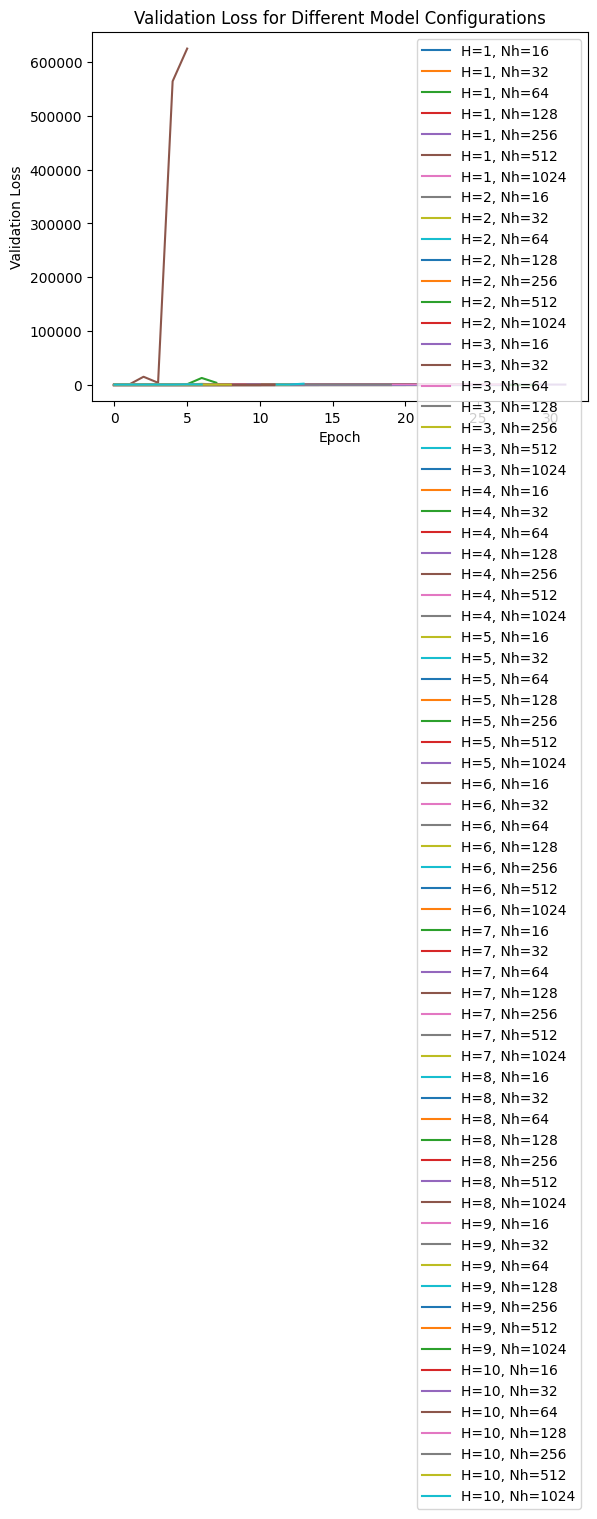

Model with H=1 and Nh=16:
MSE: 0.6350194811820984
MAE: 0.6350193023932106
RMSE: 4.048810520111478
R-squared: 0.8753391126600106
MAPE: 22.237023907092084%
Model with H=1 and Nh=32:
MSE: 0.6154088377952576
MAE: 0.6154088621995292
RMSE: 3.5226592065709124
R-squared: 0.9066893136680964
MAPE: 17.40388312827411%
Model with H=1 and Nh=64:
MSE: 0.5761651992797852
MAE: 0.5761649439208767
RMSE: 3.6309623251683196
R-squared: 0.9243898370402858
MAPE: 15.270205735696523%
Model with H=1 and Nh=128:
MSE: 0.5050141215324402
MAE: 0.5050141329148378
RMSE: 2.16253425778545
R-squared: 0.9351287789231881
MAPE: 15.4568728517087%
Model with H=1 and Nh=256:
MSE: 0.46670445799827576
MAE: 0.4667043896839233
RMSE: 1.9399849563886706
R-squared: 0.9762117115759738
MAPE: 13.527700382692121%
Model with H=1 and Nh=512:
MSE: 0.4274139404296875
MAE: 0.42741392371496995
RMSE: 1.8989507808041775
R-squared: 0.9569567724821536
MAPE: 12.237846895537665%
Model with H=1 and Nh=1024:
MSE: 0.3833453357219696
MAE: 0.383345313363

In [4]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(7, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


### Ranking

In [5]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=4, Nh=128 - MSE: 0.20550620555877686
Rank 2: Combination H=5, Nh=128 - MSE: 0.21865740418434143
Rank 3: Combination H=5, Nh=256 - MSE: 0.22050777077674866
Rank 4: Combination H=6, Nh=256 - MSE: 0.2245718389749527
Rank 5: Combination H=4, Nh=256 - MSE: 0.3074520528316498
Rank 6: Combination H=4, Nh=64 - MSE: 0.3089683949947357
Rank 7: Combination H=6, Nh=512 - MSE: 0.3165842592716217
Rank 8: Combination H=5, Nh=64 - MSE: 0.3178572952747345
Rank 9: Combination H=6, Nh=128 - MSE: 0.3223896026611328
Rank 10: Combination H=4, Nh=512 - MSE: 0.32696080207824707
Rank 11: Combination H=7, Nh=256 - MSE: 0.33274292945861816
Rank 12: Combination H=3, Nh=512 - MSE: 0.3486884832382202
Rank 13: Combination H=7, Nh=128 - MSE: 0.35092875361442566
Rank 14: Combination H=5, Nh=512 - MSE: 0.3585015833377838
Rank 15: Combination H=6, Nh=32 - MSE: 0.35925936698913574
Rank 16: Combination H=6, Nh=64 - MSE: 0.36011776328086853
Rank 17: Combination H=7, Nh=16 - MSE: 0.3664790093898773
Ran

Rank 1: Combination H=5, Nh=256 - MSE: 0.2685861587524414
Rank 2: Combination H=5, Nh=512 - MSE: 0.26927897334098816
Rank 3: Combination H=4, Nh=1024 - MSE: 0.2832221984863281
Rank 4: Combination H=4, Nh=512 - MSE: 0.29064759612083435
Rank 5: Combination H=6, Nh=1024 - MSE: 0.3075002133846283
Rank 6: Combination H=7, Nh=256 - MSE: 0.32315966486930847
Rank 7: Combination H=3, Nh=256 - MSE: 0.3244527578353882
Rank 8: Combination H=4, Nh=128 - MSE: 0.32607361674308777
Rank 9: Combination H=4, Nh=256 - MSE: 0.3269226551055908
Rank 10: Combination H=5, Nh=1024 - MSE: 0.33056139945983887
Rank 11: Combination H=4, Nh=64 - MSE: 0.3360600769519806
Rank 12: Combination H=3, Nh=512 - MSE: 0.3548477292060852
Rank 13: Combination H=7, Nh=128 - MSE: 0.36053985357284546
Rank 14: Combination H=6, Nh=64 - MSE: 0.36217623949050903
Rank 15: Combination H=3, Nh=1024 - MSE: 0.3668963313102722

In [6]:
# Specify the combination you want to call
H = 4
Nh = 128

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model
selected_model.save("model_4_128_20_20_20_20.h5")
# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Evaluate the model on the testing set
mse = selected_model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

196/750 [======>.......................] - ETA: 0s

d:\Krishna\Python_3_92\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 0s 543us/step - loss: 0.2055
Mean Squared Error on Testing Set: 0.20550620555877686
Predictions:
[[9.90800953e+00 4.67262447e-01 1.69160020e+00 1.69431353e+00
  8.83712247e-02 1.35491943e+00 5.85162677e-02]
 [0.00000000e+00 1.86347297e-05 1.33385158e+00 1.34952033e+00
  1.15747110e-03 3.01938891e-01 1.29765347e-01]
 [7.24926901e+00 7.95484483e-01 1.71352434e+00 1.71435988e+00
  5.20067401e-02 1.64009571e+00 5.15394397e-02]
 [8.46282005e+00 2.11883354e+00 2.50375986e+00 2.50149083e+00
  1.43242618e-02 1.12073815e+00 5.08477576e-02]
 [1.54295664e+01 7.52879858e+00 1.62827027e+00 1.62904823e+00
  1.17291650e-02 6.56860828e-01 1.14402704e-01]]
True Values:
[[1.03131378e+01 4.13992151e-01 1.68153236e+00 1.68153236e+00
  7.19429836e-02 1.63623509e+00 6.50622125e-02]
 [1.57412647e+00 5.88833103e-01 1.55288744e+00 1.55288744e+00
  7.44111990e-03 4.64687549e-01 1.37156431e-01]
 [7.26807243e+00 7.49825031e-01 1.70935463e+00 1.70935463e+00
  5.27434900e-

# Different dataset (15^4)

In [19]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df_1 = pd.read_csv(r"simulation_results_new_20_20_20_20.csv")

# Extract input features (L, C, fsw)
X_1 = df[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y_1 = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu", "P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled_1 = custom_scaling(X)
print(X_scaled_1[90:])

# Split the dataset into training, validation, and testing sets
X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(X_scaled_1, y_1, test_size=0.3, random_state=42)
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_temp_1, y_temp_1, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories_1 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_1 = {}
maes_1 = {}
rmses_1 = {}
r2_scores_1 = {}
mapes_1 = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512, 1024]  # Number of neurons per hidden layer

[[0.         0.01020408 0.5        1.        ]
 [0.         0.01020408 0.58333333 0.        ]
 [0.         0.01020408 0.58333333 0.08272506]
 ...
 [1.         0.18367347 1.         0.83333333]
 [1.         0.18367347 1.         0.91727494]
 [1.         0.18367347 1.         1.        ]]


Epoch 1/100, Loss: 3.489712953567505, Val Loss: 2.4688029289245605
Epoch 2/100, Loss: 2.5453057289123535, Val Loss: 2.3338730335235596
Epoch 3/100, Loss: 2.4760422706604004, Val Loss: 2.2302775382995605
Epoch 4/100, Loss: 2.396348476409912, Val Loss: 2.1415443420410156
Epoch 5/100, Loss: 2.296962261199951, Val Loss: 2.0141026973724365
Epoch 6/100, Loss: 2.200871229171753, Val Loss: 1.9088417291641235
Epoch 7/100, Loss: 2.0895140171051025, Val Loss: 1.7747337818145752
Epoch 8/100, Loss: 1.9184011220932007, Val Loss: 1.5362523794174194
Epoch 9/100, Loss: 1.7857029438018799, Val Loss: 1.4425824880599976
Epoch 10/100, Loss: 1.7194182872772217, Val Loss: 1.2804067134857178
Epoch 11/100, Loss: 1.6672863960266113, Val Loss: 1.2435415983200073
Epoch 12/100, Loss: 1.641161561012268, Val Loss: 1.1990922689437866
Epoch 13/100, Loss: 1.6094070672988892, Val Loss: 1.1786489486694336
Epoch 14/100, Loss: 1.6219031810760498, Val Loss: 1.1709362268447876
Epoch 15/100, Loss: 1.598440408706665, Val Loss:

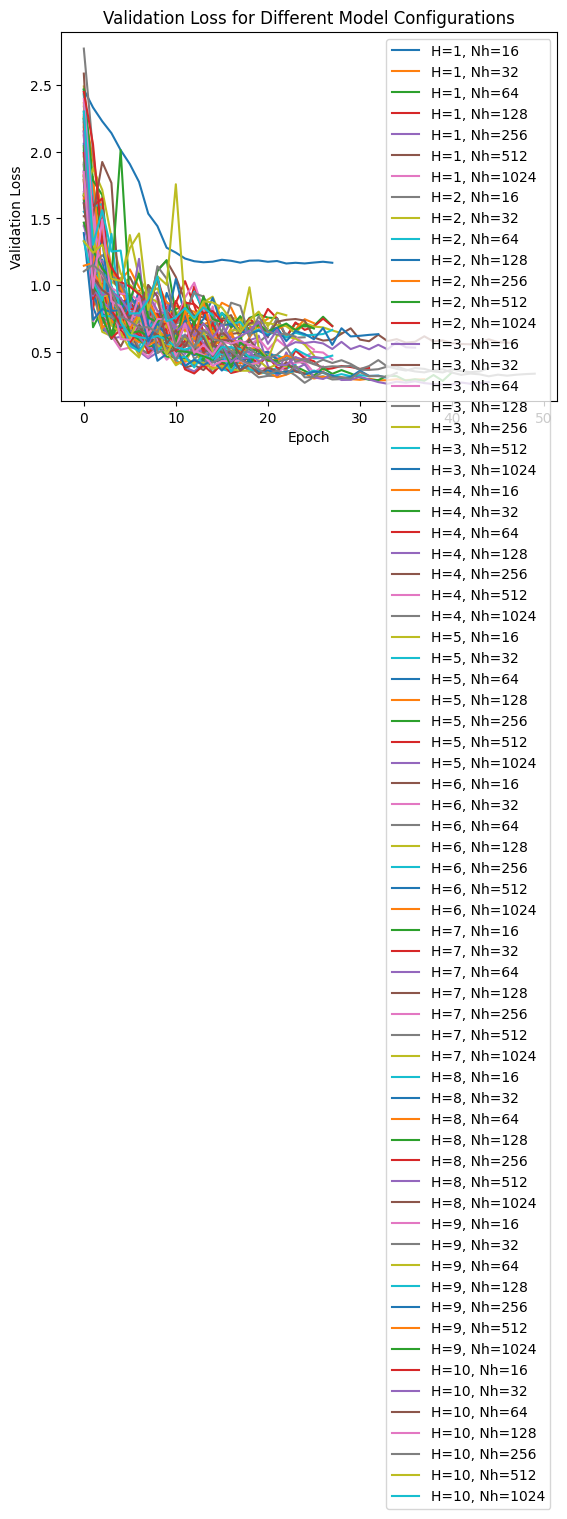

Model with H=1 and Nh=16:
MSE: 1.129625916481018
MAE: 1.1296260713441355
RMSE: 8.72690705641313
R-squared: 0.782463310002356
MAPE: 22.74456081704144%
Model with H=1 and Nh=32:
MSE: 0.660459041595459
MAE: 0.6604589372991134
RMSE: 4.574242285470764
R-squared: 0.9196487401281657
MAPE: 17.70103199186651%
Model with H=1 and Nh=64:
MSE: 0.6047598123550415
MAE: 0.6047598646586049
RMSE: 3.3846411799425717
R-squared: 0.9438107530938933
MAPE: 15.468880059835419%
Model with H=1 and Nh=128:
MSE: 0.6141096949577332
MAE: 0.6141097500759054
RMSE: 3.5234548280905846
R-squared: 0.949346091791156
MAPE: 14.636942915656142%
Model with H=1 and Nh=256:
MSE: 0.6311825513839722
MAE: 0.631182405439013
RMSE: 5.076998648618347
R-squared: 0.8999547807017312
MAPE: 14.419749211368341%
Model with H=1 and Nh=512:
MSE: 0.6110354065895081
MAE: 0.6110352557492126
RMSE: 4.020543093012793
R-squared: 0.9023751805939738
MAPE: 16.01491985533979%
Model with H=1 and Nh=1024:
MSE: 0.5774250030517578
MAE: 0.5774250305509486
RMSE

In [20]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_1 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_1.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_1.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_1.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_1.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_1.add(tf.keras.layers.Dense(7, activation='softplus'))  

        # Compile the model
        model_1.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_1 = model_1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val_1, y_val_1), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_1[(H, Nh)] = history_1

        # Evaluate the model on the testing set
        predictions_1 = model_1.predict(X_test_1)

        # Evaluate the model on the testing set and calculate MSE
        mse_1 = model_1.evaluate(X_test_1, y_test_1)
        mses_1[(H, Nh)] = mse_1

        # Calculate Mean Absolute Error (MAE)
        mae_1 = mean_absolute_error(y_test_1, predictions_1)
        maes_1[(H, Nh)] = mae_1

        # Calculate Root Mean Squared Error (RMSE)
        rmse_1 = np.sqrt(mean_squared_error(y_test_1, predictions_1))
        rmses_1[(H, Nh)] = rmse_1

        # Calculate R-squared (R2) Score
        r2_1 = r2_score(y_test_1, predictions_1)
        r2_scores_1[(H, Nh)] = r2_1

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_1 = np.mean(np.abs((y_test_1 - predictions_1) / y_test_1)) * 100
        mapes_1[(H, Nh)] = mape_1

# Plot the validation loss for each configuration
for (H, Nh), history_1 in histories_1.items():
    plt.plot(history_1.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse_1 in mses_1.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_1}')
    print(f'MAE: {maes_1[(H, Nh)]}')
    print(f'RMSE: {rmses_1[(H, Nh)]}')
    print(f'R-squared: {r2_scores_1[(H, Nh)]}')
    print(f'MAPE: {mapes_1[(H, Nh)]}%')


In [21]:
# Rank combinations based on their MSE values
ranked_combinations_1 = sorted(mses_1.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_1) in enumerate(ranked_combinations_1, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_1}")


Rank 1: Combination H=5, Nh=1024 - MSE: 0.24989311397075653
Rank 2: Combination H=4, Nh=1024 - MSE: 0.25332745909690857
Rank 3: Combination H=5, Nh=256 - MSE: 0.26306357979774475
Rank 4: Combination H=5, Nh=128 - MSE: 0.2938171923160553
Rank 5: Combination H=7, Nh=512 - MSE: 0.3085176348686218
Rank 6: Combination H=6, Nh=512 - MSE: 0.31167203187942505
Rank 7: Combination H=6, Nh=256 - MSE: 0.3126179277896881
Rank 8: Combination H=4, Nh=512 - MSE: 0.31844809651374817
Rank 9: Combination H=10, Nh=256 - MSE: 0.32568618655204773
Rank 10: Combination H=6, Nh=64 - MSE: 0.3365779221057892
Rank 11: Combination H=5, Nh=512 - MSE: 0.3376925587654114
Rank 12: Combination H=3, Nh=512 - MSE: 0.33899661898612976
Rank 13: Combination H=4, Nh=128 - MSE: 0.3397841155529022
Rank 14: Combination H=7, Nh=128 - MSE: 0.3400576710700989
Rank 15: Combination H=6, Nh=128 - MSE: 0.34858980774879456
Rank 16: Combination H=4, Nh=256 - MSE: 0.364061176776886
Rank 17: Combination H=4, Nh=64 - MSE: 0.369510740041732

### Try spesific N and H

In [22]:
# Specify the combination you want to call
H = 5
Nh = 1024

# Retrieve the model for the specified combination
selected_model_1 = histories_1[(H, Nh)].model
selected_model_1.save("model_5_1024_15_15_15_15.h5")
# Use the trained model to make predictions on the testing set
predictions_1 = selected_model_1.predict(X_test_1)

# Evaluate the model on the testing set
mse_1 = selected_model_1.evaluate(X_test_1, y_test_1)
print("Mean Squared Error on Testing Set:", mse_1)

# Print the first few predictions
print("Predictions:")
print(predictions_1[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_1[:5])

d:\Krishna\Python_3_92\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


134/134 [==============================] - 0s 3ms/step - loss: 0.2499
Mean Squared Error on Testing Set: 0.24989311397075653
Predictions:
[[4.3977466e+00 4.6434447e-01 1.7487903e+00 1.7401148e+00 2.4564873e-02
  9.7927451e-01 1.2027615e-01]
 [1.8035984e+01 5.2553568e+00 1.3065366e+00 1.3035849e+00 1.6488011e-03
  1.9935820e-01 1.3207436e-01]
 [1.6973906e+01 2.4805527e+00 1.9173111e+00 1.9158671e+00 1.2477843e-02
  4.9686888e-01 1.2632068e-01]
 [4.1378069e+00 1.0608995e+00 2.0673270e+00 2.0661361e+00 8.7880660e-03
  9.2924935e-01 1.2281534e-01]
 [1.9489346e+01 6.5418119e+00 1.9629730e+00 1.9656271e+00 2.4244696e-02
  1.1453820e+00 3.8663704e-02]]
True Values:
[[4.76080528e+00 5.25655146e-01 1.67239255e+00 1.67239255e+00
  1.99805977e-02 9.73727435e-01 1.21483470e-01]
 [2.13022187e+01 4.20957287e+00 1.32108197e+00 1.32108197e+00
  9.90812382e-04 1.72777606e-01 1.30921004e-01]
 [1.65742053e+01 2.70162061e+00 1.91680832e+00 1.91680832e+00
  9.07691085e-03 4.61170538e-01 1.27955992e-01]
 [4

## Testing Set

In [31]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# # Print the first few predictions
# print("Predictions:")
# print(predictions[:5])

# # Print the corresponding true values
# print("True Values:")
# print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

  1/134 [..............................] - ETA: 1s - loss: 0.3383

134/134 [==============================] - 0s 828us/step - loss: 0.2739
Mean Squared Error on Testing Set: 0.2739008665084839
134/134 [==============================] - 0s 840us/step
Mean Absolute Error (MAE): 0.27390079014170265
Root Mean Squared Error (RMSE): 1.9634872386854565
R-squared (R2) Score: 0.6528700251194317
Mean Absolute Percentage Error (MAPE): 11.044990309908982%


## Save Model

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")
